In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from data_preprocessing.DataLoader import DataLoader
from sklearn.preprocessing import StandardScaler

In [6]:
def unite_sets(deliveries, products, sessions, users):
    deliveries["deltas"] = deliveries["delivery_timestamp"] - deliveries["purchase_timestamp"]

    # divide category
    categories = products.category_path.str.split(';', expand=True)
    products = pd.concat([products, categories], axis=1)
    products = products.drop(columns=['category_path'])
    products = products.rename(
        columns={0: "primary_category", 1: "secondary_category", 2: "tertiary_category", 3: "quaternary_category"})


    deliveries_sessions = pd.merge(deliveries, sessions, left_on="purchase_id", right_on="purchase_id")
    deliveries_sessions_users = pd.merge(deliveries_sessions, users, left_on="user_id", right_on="user_id")
    deliveries_sessions_users_products = pd.merge(deliveries_sessions_users, products, left_on="product_id", right_on="product_id")

    deliveries_sessions_users_products.to_csv('../out.csv')
    return deliveries_sessions_users_products

In [7]:
#Function for labeling rows
def labelTimeOfDay(row):
    hour = row['purchase_timestamp'].hour
    if(hour >= 6 and hour < 12):
        return "Morning"
    elif(hour >= 12 and hour < 18):
        return "Afternoon"
    elif(hour >=18 and hour < 24):
        return "Evening"
    else:
        return "Night"

In [8]:
def one_hot_encode(united, s):
    y = pd.get_dummies(united[s], prefix=s)
    united = united.join(other=y)
    united = united.loc[:, united.columns != s]
    return united

In [9]:
d = DataLoader.load_data_from_path("data")

products = d.products
deliveries = d.deliveries
sessions = d.sessions
users = d.users

united = unite_sets(deliveries, products, sessions, users)

# nie wnosi zadnej informacji wiec wyrzucamy daną kolumnę
united = united.loc[:, united.columns != 'event_type']
united = united.loc[:, united.columns != 'name']
united = united.loc[:, united.columns != 'street']
united = united.loc[:, united.columns != 'product_name']
united = united.loc[:, united.columns != 'delivery_timestamp']
united = united.loc[:, united.columns != 'timestamp']
united = united.loc[:, united.columns != 'purchase_id']
united = united.loc[:, united.columns != 'product_id']
united = united.loc[:, united.columns != 'user_id']
united = united.loc[:, united.columns != 'session_id']
# united = united.loc[:, united.columns != 'offered_discount']
# united = united.loc[:, united.columns != 'price']
united = united.loc[:, united.columns != 'primary_category']
united = united.loc[:, united.columns != 'secondary_category']
united = united.loc[:, united.columns != 'tertiary_category']
united = united.loc[:, united.columns != 'quaternary_category']

united.loc[:,'time_of_day'] = united.apply(lambda row: labelTimeOfDay(row), axis=1)
united['weekday'] = united['purchase_timestamp'].dt.day_name()
united = united.loc[:, united.columns != 'purchase_timestamp']



# y = pd.get_dummies(united.city, prefix='city')
# united = united.join(other=y)
# united = united.loc[:, united.columns != 'city']

# y = pd.get_dummies(united.delivery_company, prefix='delivery_company')
# united = united.join(other=y)
# united = united.loc[:, united.columns != 'delivery_company']

# y = pd.get_dummies(united.time_of_day, prefix='time_of_day')
# united = united.join(other=y)
# united = united.loc[:, united.columns != 'time_of_day']

# y = pd.get_dummies(united.weekday, prefix='weekday')
# united = united.join(other=y)
# united = united.loc[:, united.columns != 'weekday']

united = one_hot_encode(united, 'city')
united = one_hot_encode(united, 'delivery_company')
united = one_hot_encode(united, 'time_of_day')
united = one_hot_encode(united, 'weekday')
# united = one_hot_encode(united, 'primary_category')
# united = one_hot_encode(united, 'secondary_category')
# united= one_hot_encode(united, 'tertiary_category')
# united = one_hot_encode(united, 'quaternary_category')

united['deltas'] = pd.to_numeric(united['deltas'].dt.days, downcast='integer')


# normalizacja deltas
# unitated['deltas'] = unitated['deltas'] /unitated['deltas'].abs().max()


# train, test = train_test_split(unitated, test_size=0.2)
# X_train = train.loc[:, train.columns != 'deltas']
# y_train = train['deltas']

# X_test = test.loc[:, test.columns != 'deltas']
# y_test = test['deltas']

In [10]:
x = united.drop('deltas', axis=1)
y = united['deltas']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# #Scaling
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [11]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [12]:
y_pred = model.predict(X_test)

In [13]:
y_pred

array([0, 0, 3, ..., 1, 2, 1], dtype=int8)

In [14]:
accuracy = accuracy_score(y_test, y_pred)*100

In [15]:
accuracy

42.361574382921944

<function matplotlib.pyplot.show(close=None, block=None)>

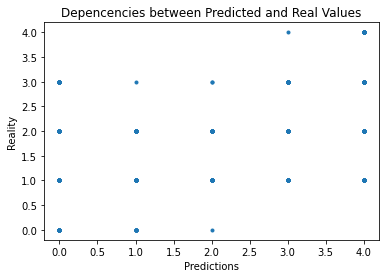

In [16]:
plt.plot(y_pred, y_test,".")
plt.title("Depencencies between Predicted and Real Values")
plt.xlabel("Predictions")
plt.ylabel("Reality")
plt.show

In [26]:
import pickle
f = open('models/bayes.pickle', 'wb')
pickle.dump(model, f)
f.close()